# Vanilla GAN Implementation for MNIST Dataset

# Importing Necessary Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display
import time

# The Power of Preprocessing: Preparing MNIST for a Creative Journey!

In [2]:
# Load and preprocess the dataset
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5  # Normalize to [-1, 1]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS=100
DIM = 100

In [4]:
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Displaying data

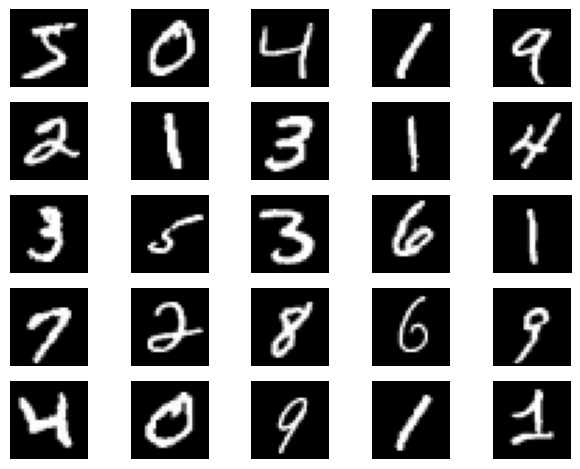

In [5]:
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[i],cmap="gray")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Meet the Genius: Efficient Generator Architecture at Your Service!

In [6]:
def make_generator_model():
    model = Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape = (DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7,7,256)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(128,(5,5), strides=(1,1), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5,5),strides = (2,2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1,(5,5),strides=(2,2), padding="same", use_bias=False,activation="tanh")
    ])
    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


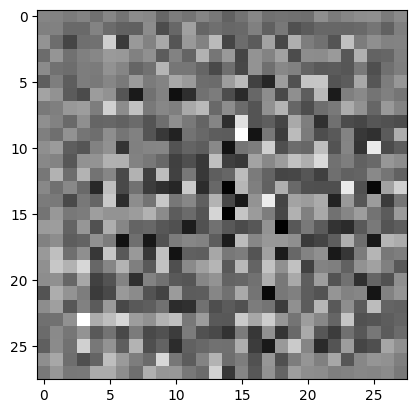

In [7]:
generator = make_generator_model()
noise = tf.random.normal([1,DIM])
generated_image = generator(noise,training=False)
plt.imshow(generated_image[0,:,:,0],cmap="gray")

# A Battle of Minds: Discriminator Decides What's Real and What's Fake!

In [8]:
def make_discriminator_model():
    model = Sequential([
        layers.Conv2D(64, (5,5), padding="same",input_shape=[28,28,1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128,(5,5),padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1,activation="sigmoid")
    ])
    return model

In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.49992013]], shape=(1, 1), dtype=float32)


# Loss Functions That Lead the Way: Training a GAN to Perfection!

In [10]:
# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Unveiling the Magic of GANs: Transforming Noise into Art!

In [11]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [12]:
# Image generation function with inline display
def generate_image(model, epoch, test_input):
    prediction = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(prediction.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(prediction[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

In [13]:
# Training function
def train(dataset, epochs):
    seed = tf.random.normal([16, DIM])
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)


        generate_image(generator, epoch + 1, seed)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    generate_image(generator, epochs, seed)

# Watch Creativity Unfold: The Final Touch — Generating Stunning Images!

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


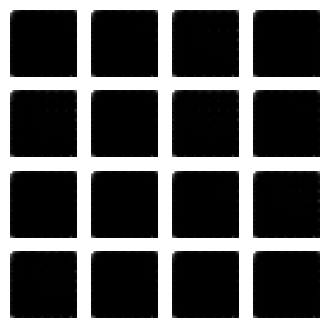

Time for epoch 1 is 37.33622884750366 sec


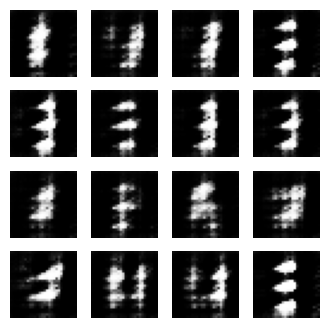

Time for epoch 2 is 24.83366823196411 sec


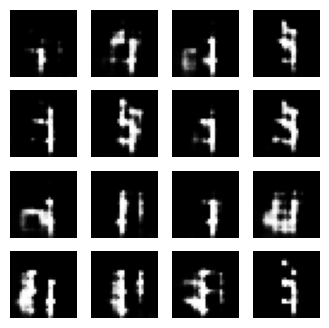

Time for epoch 3 is 25.111895322799683 sec


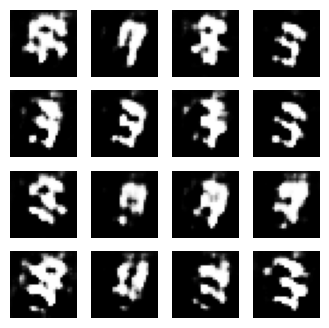

Time for epoch 4 is 25.6579270362854 sec


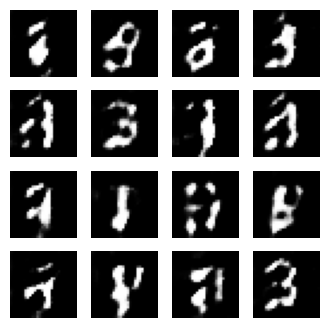

Time for epoch 5 is 25.597267389297485 sec


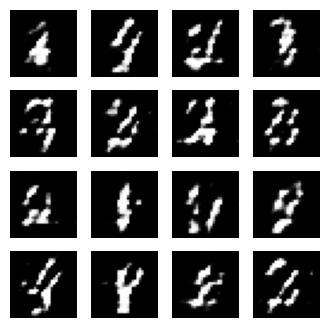

Time for epoch 6 is 25.684890508651733 sec


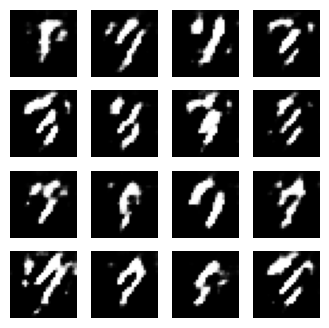

Time for epoch 7 is 25.791452884674072 sec


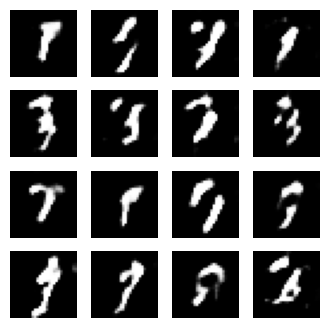

Time for epoch 8 is 25.90340495109558 sec


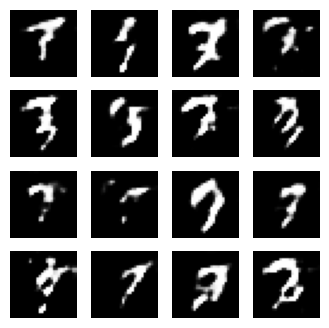

Time for epoch 9 is 26.04790496826172 sec


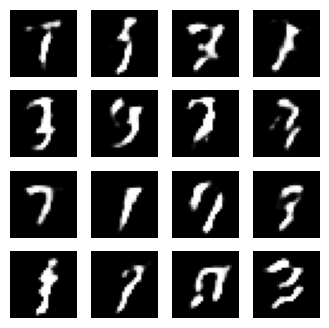

Time for epoch 10 is 26.108549118041992 sec


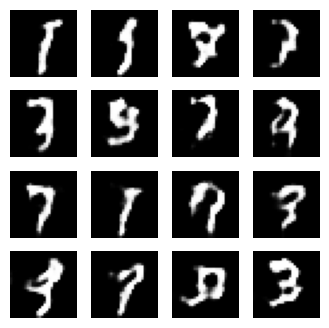

Time for epoch 11 is 26.562854290008545 sec


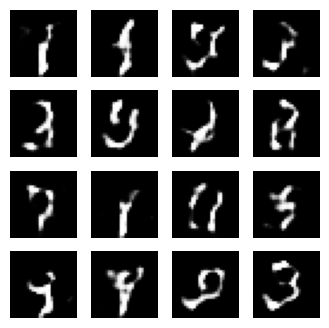

Time for epoch 12 is 26.26830005645752 sec


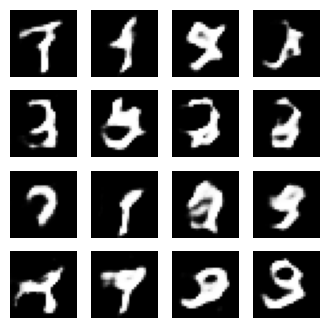

Time for epoch 13 is 26.289849996566772 sec


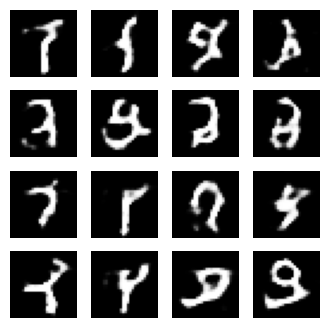

Time for epoch 14 is 26.33663320541382 sec


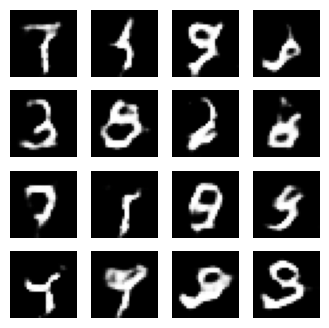

Time for epoch 15 is 26.43059277534485 sec


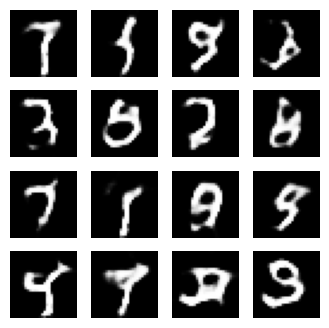

Time for epoch 16 is 26.418938398361206 sec


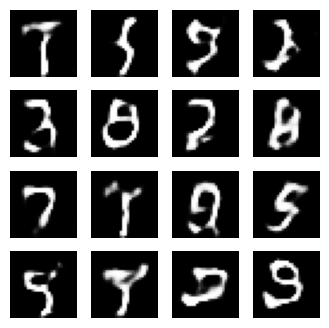

Time for epoch 17 is 26.732086896896362 sec


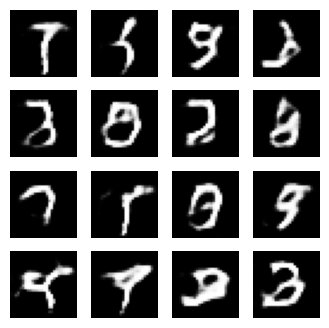

Time for epoch 18 is 26.370126962661743 sec


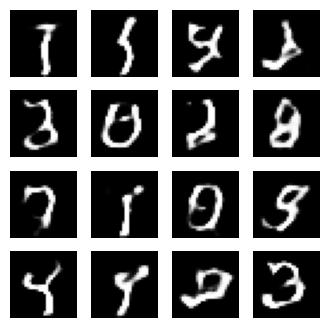

Time for epoch 19 is 26.340234518051147 sec


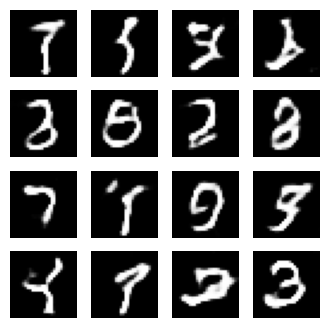

Time for epoch 20 is 26.422606945037842 sec


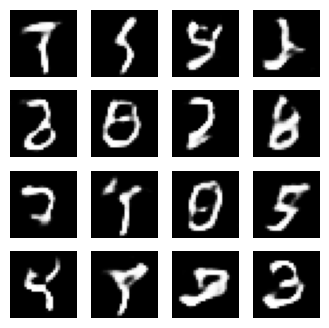

Time for epoch 21 is 26.40649151802063 sec


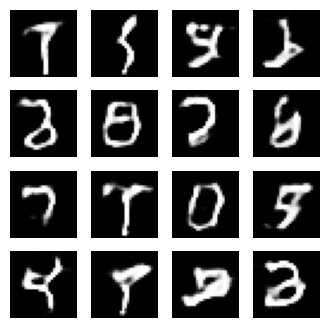

Time for epoch 22 is 26.39352250099182 sec


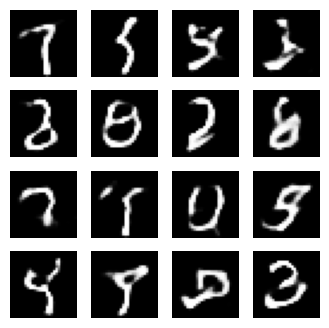

Time for epoch 23 is 26.697672367095947 sec


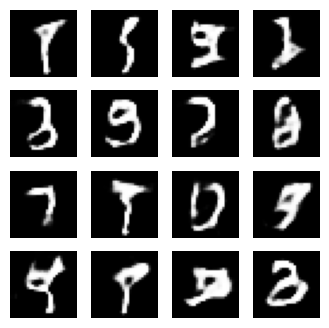

Time for epoch 24 is 26.38064694404602 sec


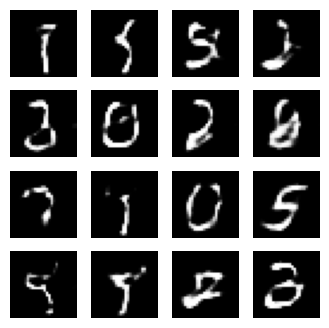

Time for epoch 25 is 26.488185167312622 sec


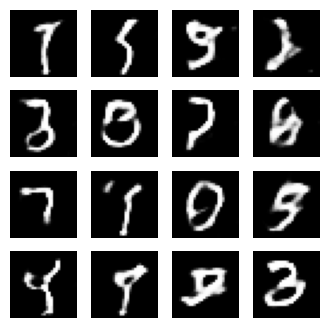

Time for epoch 26 is 26.418565034866333 sec


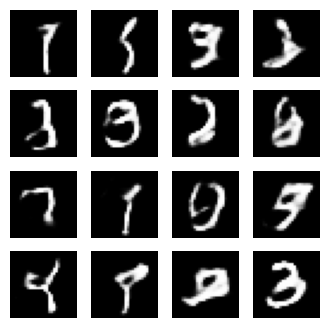

Time for epoch 27 is 26.392166137695312 sec


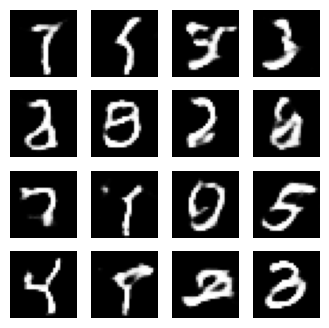

Time for epoch 28 is 26.389789581298828 sec


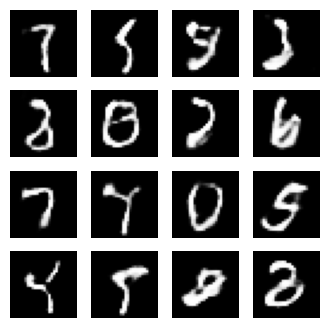

Time for epoch 29 is 26.7786648273468 sec


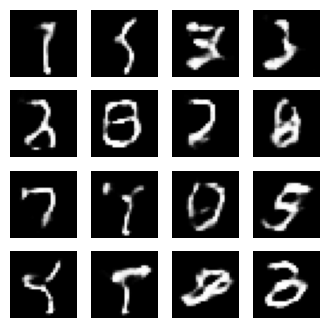

Time for epoch 30 is 26.43351912498474 sec


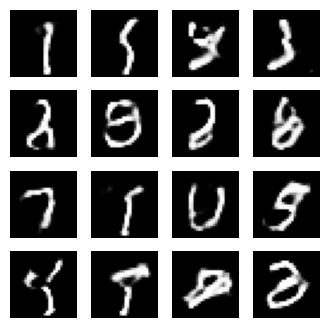

Time for epoch 31 is 26.39939284324646 sec


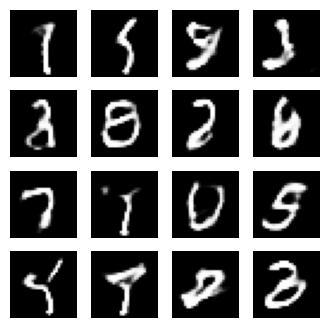

Time for epoch 32 is 26.38371253013611 sec


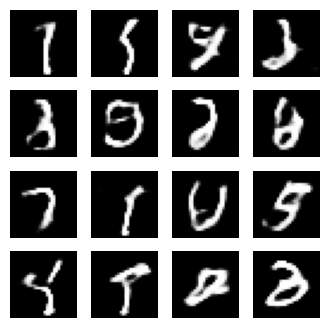

Time for epoch 33 is 26.392170906066895 sec


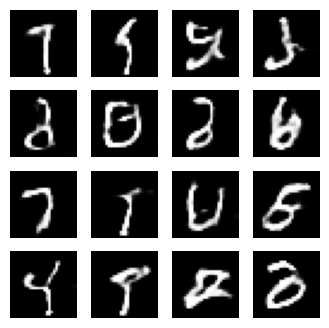

Time for epoch 34 is 26.46457076072693 sec


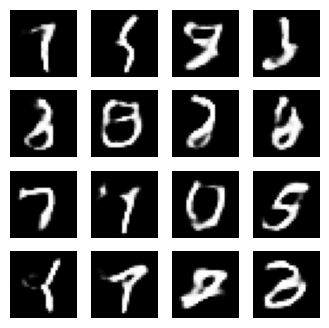

Time for epoch 35 is 26.435152053833008 sec


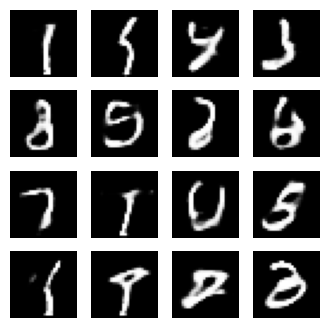

Time for epoch 36 is 26.71688747406006 sec


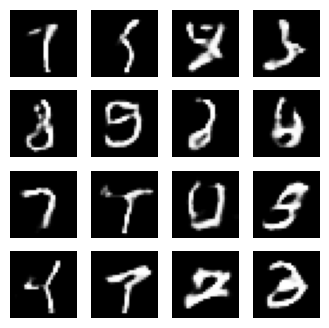

Time for epoch 37 is 26.37374472618103 sec


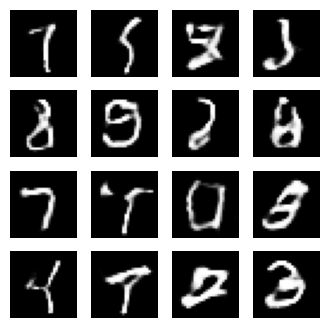

Time for epoch 38 is 26.37196373939514 sec


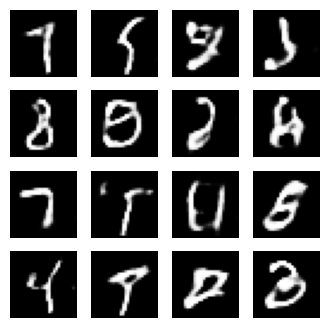

Time for epoch 39 is 26.45743441581726 sec


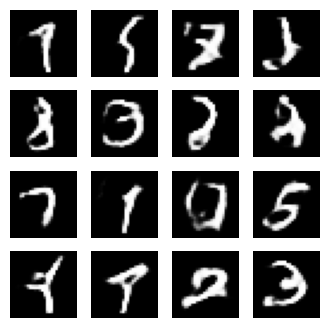

Time for epoch 40 is 26.42807364463806 sec


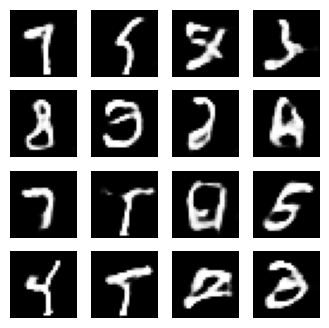

Time for epoch 41 is 26.386313438415527 sec


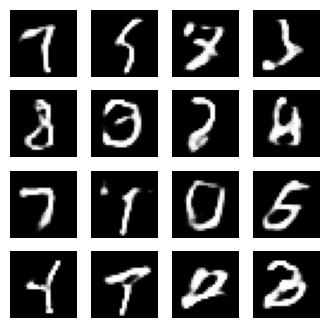

Time for epoch 42 is 26.699503183364868 sec


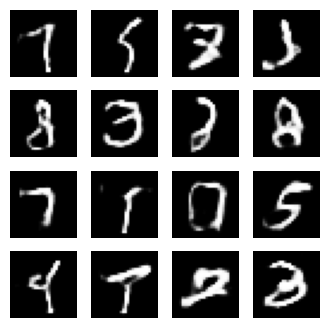

Time for epoch 43 is 26.407159090042114 sec


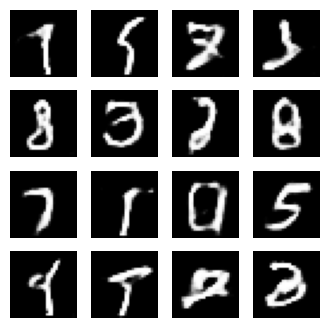

Time for epoch 44 is 26.396189212799072 sec


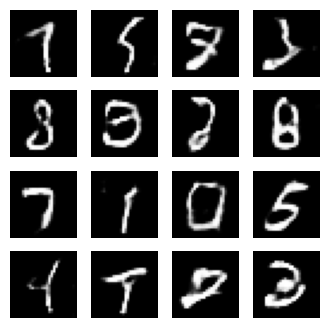

Time for epoch 45 is 26.413686513900757 sec


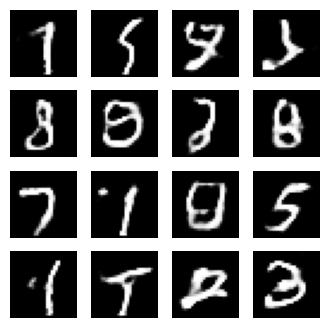

Time for epoch 46 is 26.395184993743896 sec


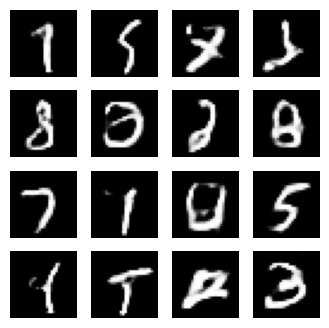

Time for epoch 47 is 26.366078853607178 sec


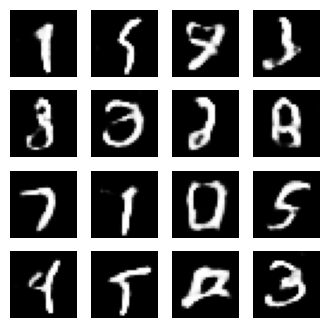

Time for epoch 48 is 26.858852863311768 sec


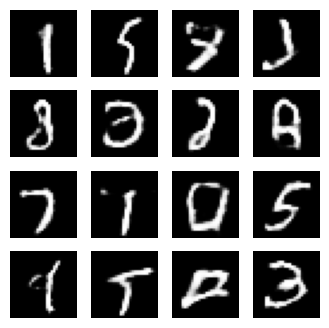

Time for epoch 49 is 26.378793478012085 sec


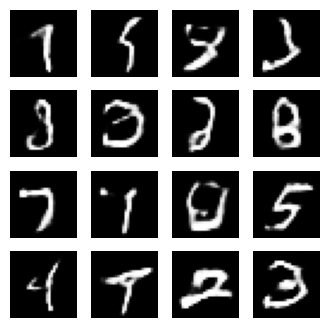

Time for epoch 50 is 26.394522428512573 sec


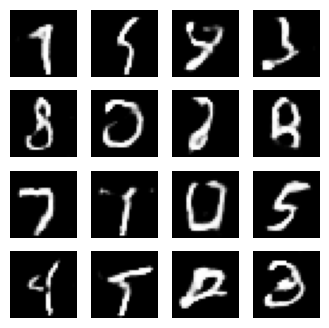

Time for epoch 51 is 26.408674001693726 sec


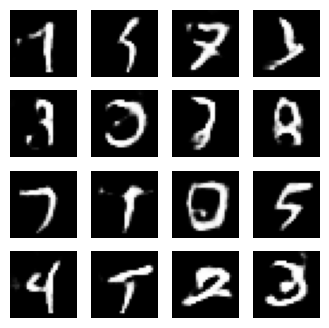

Time for epoch 52 is 26.3734233379364 sec


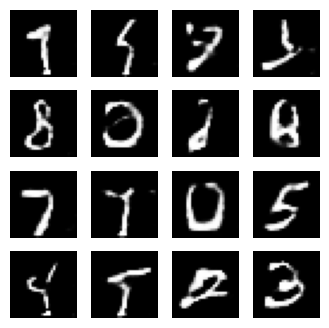

Time for epoch 53 is 26.47669267654419 sec


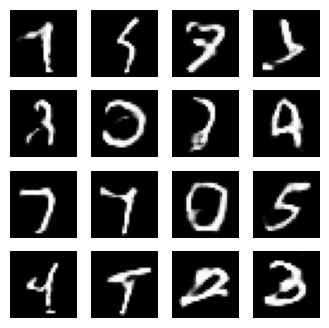

Time for epoch 54 is 26.733527898788452 sec


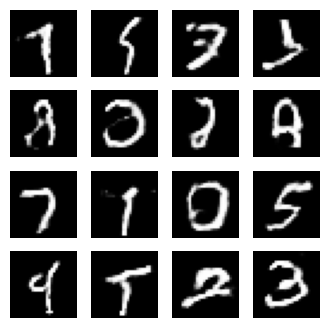

Time for epoch 55 is 26.406620502471924 sec


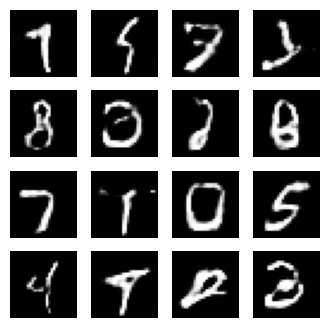

Time for epoch 56 is 26.396584033966064 sec


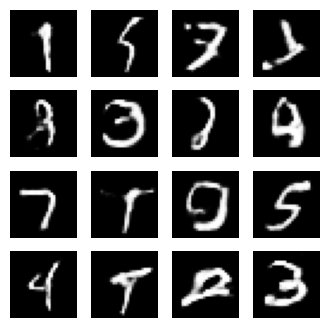

Time for epoch 57 is 26.389896392822266 sec


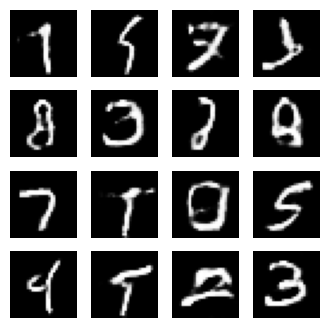

Time for epoch 58 is 26.469998598098755 sec


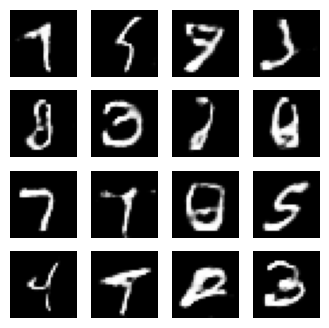

Time for epoch 59 is 26.380717515945435 sec


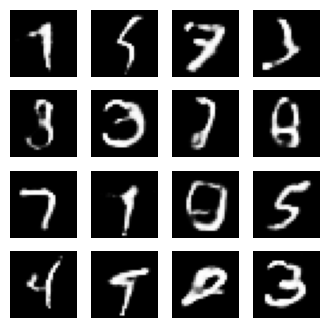

Time for epoch 60 is 26.392984628677368 sec


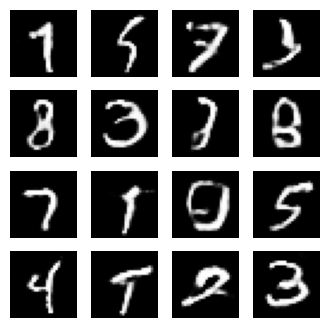

Time for epoch 61 is 26.721518754959106 sec


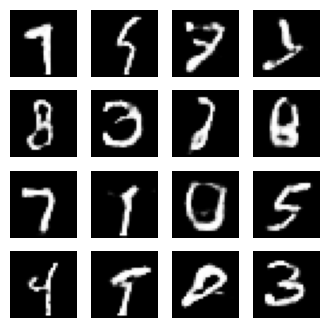

Time for epoch 62 is 26.459378004074097 sec


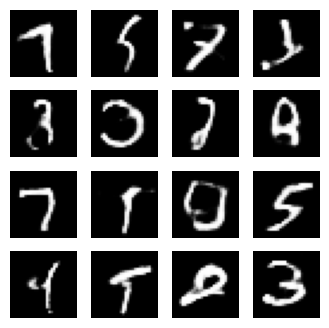

Time for epoch 63 is 26.391862154006958 sec


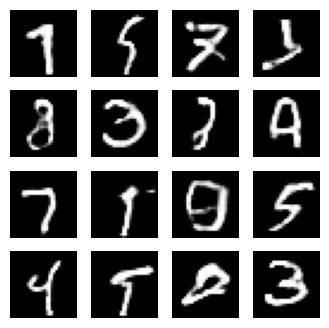

Time for epoch 64 is 26.386486291885376 sec


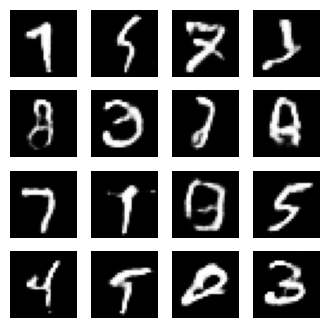

Time for epoch 65 is 26.396447896957397 sec


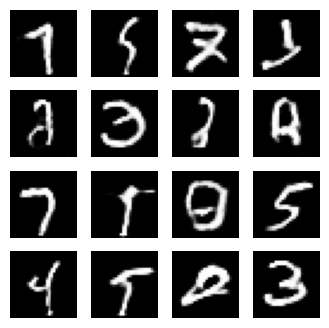

Time for epoch 66 is 26.401143312454224 sec


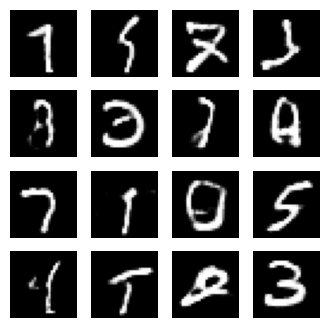

Time for epoch 67 is 26.685632944107056 sec


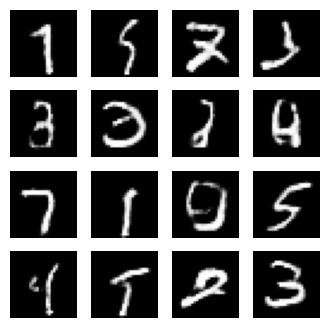

Time for epoch 68 is 26.41473412513733 sec


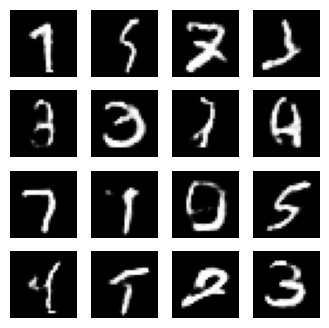

Time for epoch 69 is 26.374735116958618 sec


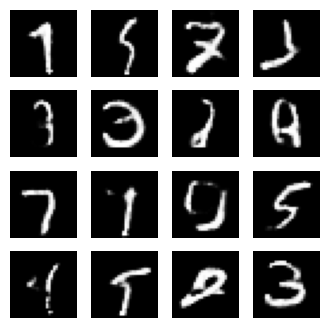

Time for epoch 70 is 26.392732620239258 sec


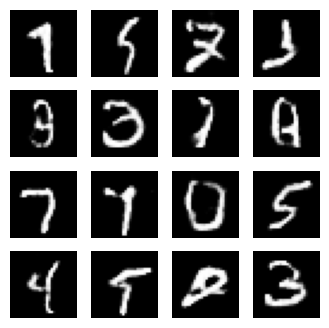

Time for epoch 71 is 26.424737453460693 sec


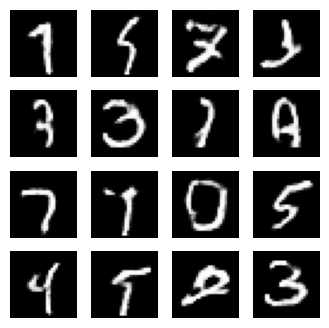

Time for epoch 72 is 26.400397300720215 sec


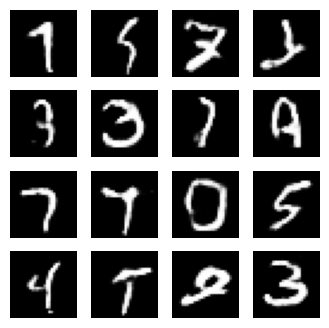

Time for epoch 73 is 26.73493790626526 sec


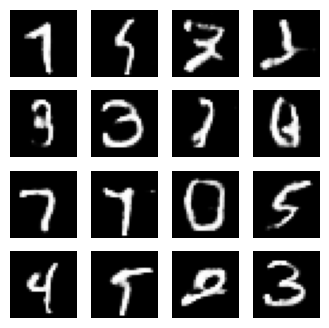

Time for epoch 74 is 26.41890287399292 sec


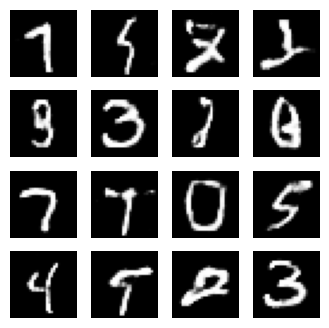

Time for epoch 75 is 26.43430185317993 sec


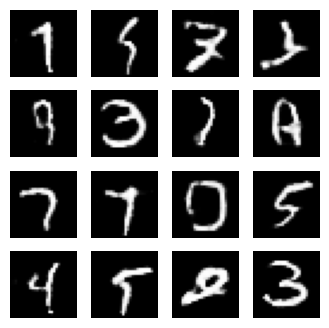

Time for epoch 76 is 26.400279998779297 sec


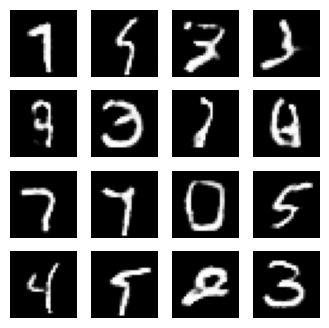

Time for epoch 77 is 26.398798942565918 sec


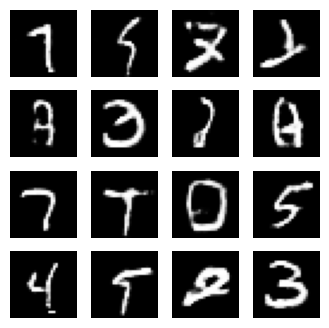

Time for epoch 78 is 26.384958505630493 sec


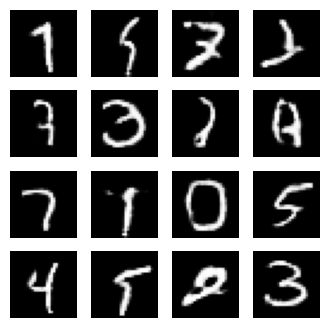

Time for epoch 79 is 26.869651794433594 sec


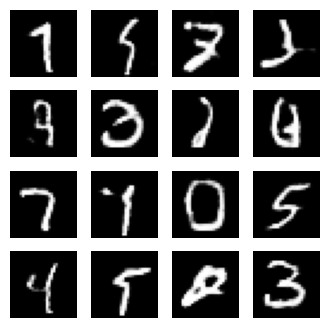

Time for epoch 80 is 26.374053955078125 sec


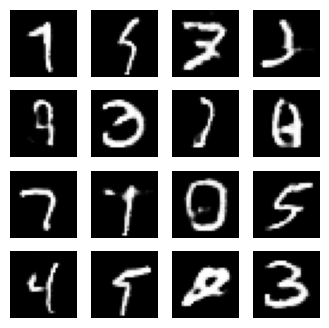

Time for epoch 81 is 26.35425901412964 sec


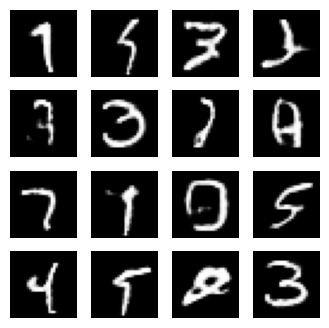

Time for epoch 82 is 26.3863422870636 sec


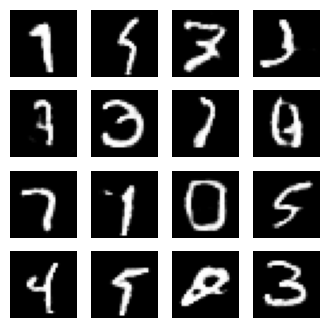

Time for epoch 83 is 26.477777004241943 sec


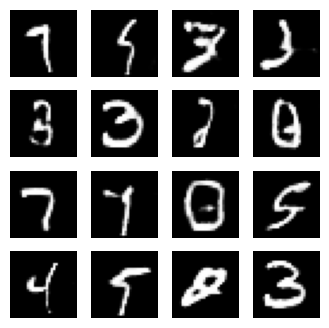

Time for epoch 84 is 26.42052960395813 sec


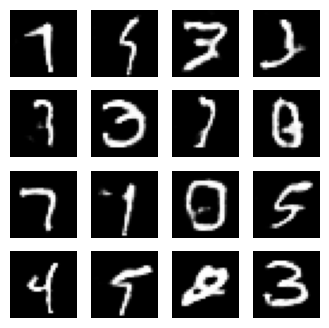

Time for epoch 85 is 26.38792395591736 sec


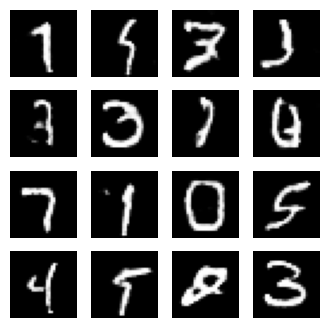

Time for epoch 86 is 26.742523431777954 sec


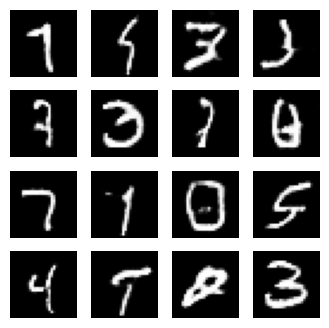

Time for epoch 87 is 26.48215937614441 sec


In [ ]:
train(dataset, EPOCHS)